In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../../')
from src.encode_data import *
from src.midi_data import *
from src.data_sources import process_all
from src.midi_transform import *
from src.fastai_data import *
from src.lmnp_transformer import *

In [14]:
from src.v1.fastai_data import MusicTokenizer
from src.v1.encode_data import seq2str_duration, str2stream

def note_enc_func(note): return note.duration_repr()

In [4]:
from fastai.text import *

## Example notebook how to encode midi to text format and train with fastai

In [5]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'

# Location of transformed midi to numpy dataset
text_path = data_path/'text'

## 1. Gather midi dataset

Make sure all your midi data is in `data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

### 2. Encode midi files to numpy

For more in customized encoding - see `notebooks/dataformatting/2-DataFormatting-AllCombined-X.ipynb`

In [5]:
midi_files = get_files(data_path, '.mid', recurse=True)
# midi_files = midi_files[:500]

In [6]:
def process_files(midi_file):
    output_file = Path(str(midi_file).replace(str(midi_path), str(text_path))).with_suffix('.txt')
    if output_file.exists(): return
    output_file.parent.mkdir(parents=True, exist_ok=True)
    
    # Part 1. Compress tracks/instruments
    textenc = transform_midi(midi_file)
    if textenc is not None: 
        with open(output_file, 'w') as f:
            f.write(textenc)

In [8]:
def transform_midi(midi_file):
    try:
        # 1. Convert file to music21 stream
        stream = file2stream(midi_file) 
        # 2. Convert to numpy array
        chordarr = stream2chordarr(stream, max_dur=DUR_RANGE-2, flat=False) 
        # 3. Create note sequence
        seq = chordarr2seq(chordarr)
        # 4. Encoded representation
        textenc = seq2str_duration(seq, note_enc_func)

    except Exception as e:
        print('Could not encode to file:', midi_file, e)
        return None
    
    return textenc

In [9]:
# transform_midi(midi_files[0])

In [ ]:
processed = process_all(process_files, midi_files, timeout=50, timeout_func=None)

## 3. Create dataset from encoded files

In [23]:
def create_databunch(files, out_path, vocab=None, batch_size=32):
    ps = [OpenFileProcessor(), 
         TokenizeProcessor(tokenizer=MusicTokenizer(), chunksize=num_cpus()*20),
         NumericalizeProcessor(vocab=vocab, max_vocab=500)]

    data = (TextList(items=files, path=out_path, processor=ps)
            .random_split_by_pct(0.01, seed=6)
            .label_for_lm()
            .databunch(bs=batch_size))
    data.save()
    return data

In [6]:
text_files = get_files(text_path, '.txt', recurse=True); len(text_files)

470

In [ ]:
data = create_databunch(text_files, text_path)

## 4. Load Model

In [8]:
data = load_data(text_path, bs=8, bptt=256)

In [9]:
learn = language_model_learner(data, TransformerXL, clip=0.5)

/home/ubuntu/fastai/fastai/text/learner.py:209: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


In [31]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.685111,1.793216,0.506535,02:47
1,1.455609,1.498293,0.580266,02:48
2,1.316328,1.358744,0.608962,02:48
3,1.355179,1.272140,0.628042,02:49


## 6. Predict from existing midi file

In [10]:
midi_files = get_files(data_path, '.mid', recurse=True)
midi_file = midi_files[0]; midi_file

PosixPath('data/midi/130k_reddit_midi/Jazz_www.thejazzpage.de_MIDIRip/phasedance.mid')

In [15]:
# Encode midi file to array for prediction
stream = file2stream(midi_file) 
chordarr = stream2chordarr(stream, max_dur=DUR_RANGE-2, flat=False)
seq = chordarr2seq(chordarr)
textenc = seq2str_duration(seq, note_enc_func)

In [16]:
# convert numpy encoding to torch tensor. 
seed_len = 100
notes = textenc.split(' ')
seed = ' '.join(notes[:seed_len]); len(notes), seed

(13852,
 '|| t32 nE5 t4 nC#5 t3 nE-3 t1 nC#2 t1 nC2 t2 nB1 t5 || t1 nE-3 t1 || t0 nE-3 t1 || t0 nA5 t2 nE-3 t1 nG#2 t1 nC2 t1 || t1 nF#5 t4 nD5 t4 nE-3 t1 nF#2 t1 nC#2 t1 || t1 nE-3 t1 nF#2 t5 || t0 nE-3 t1 || t0 nA5 t4 nE-3 t1 || t1 nE-3 t1 nG#2 t1 nC#2 t1 || t1 nE5 t4 nC#5 t3 nE-3 t1 nC2 t1 nB1 t1 || t0 nE-3 t1 || t0 nE-3 t1 nC2 t3 nB1 t5 || t1 nA5 t4 nE-3 t1 || t1')

In [ ]:
# heres' what the original file looks like
stream.flat.show()

In [17]:
out = learn.predict(seed, n_words=100)

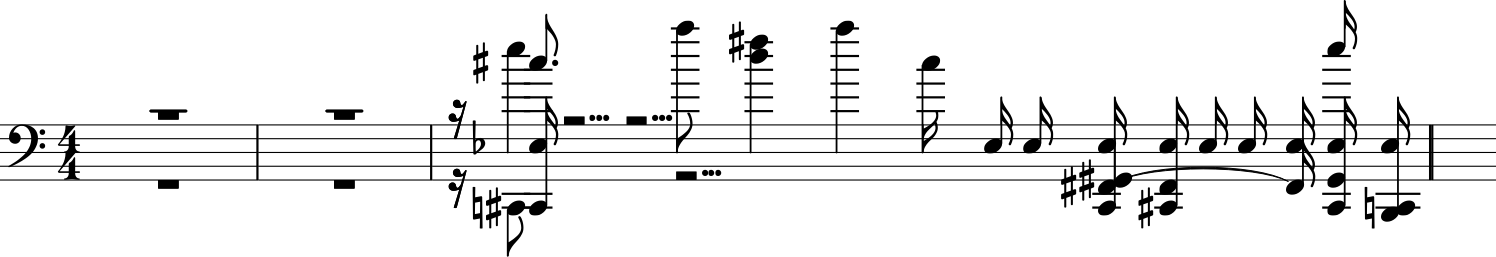

In [18]:
# Prediction
stream = str2stream(seed).show()